In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Wire Antenna Basics:  Design, Visualization, Simulation

## Specifying a wire antenna design
In the following pages we're going to specify wire antenna designs using lists of numpy arrays,
one row per endpoint:
```
my_ant = [np.array([[x0,y0,z0], 
                    [x1,y1,z1], 
                    [x2,y2,z2], 
                     ..... ])]
```
Most designs will need only one array of serially-connected segments, but some (see the cage dipole below) will require a list of several arrays.

We're adopting the convention that antenna elements run parallel to the y axis, and that NEC will mirror elements across the x-z plane, so a simple 40 meter dipole at an elevation of 20 meters would be specified as:
```
my_40m_dipole = [np.array([[0,0,20], [0,10,20]])]
```

### Some useful utility functions:

In [5]:

import numpy as np
import plotly.graph_objects as go


# Slightly simplified syntax for specifying our arrays of segments:
#  make_linear_element((0,0,0), (1,1,1), (2,3,4))   -->    [np.array([[0,0,0], [1,1,1], [2,3,4]])]
def make_linear_element(*args):
    return [np.array(args)]


# Total wire length in a design
def total_wire_len(des):
    return np.sum( [np.sum(np.linalg.norm(np.diff(arr,axis=0),axis=1)) for arr in des] )


#
# Translate and rotate antenna elements  (either a single array or list of arrays)
#
def _rot(elem,arr):
    if isinstance(elem, list):
        return [el @ arr for el in elem]
    return elem @ arr
def rot_x(elem,ang):
    return _rot(elem, np.array([[1,0,0],[0,np.cos(ang),np.sin(ang)],[0,-np.sin(ang),np.cos(ang)]]))
def rot_y(elem,ang):
    return _rot(elem, np.array([[np.cos(ang),0,-np.sin(ang)],[0,1,0],[np.sin(ang),0,np.cos(ang)]]))
def rot_z(elem,ang):
    return _rot(elem, np.array([[np.cos(ang),np.sin(ang),0],[-np.sin(ang),np.cos(ang),0],[0,0,1]]))

def translate(elem, dxyz):
    rowarr = np.array([dxyz])
    if isinstance(elem, list):
        return [el + rowarr for el in elem]
    return elem + rowarr



#
# Create a cage dipole element: cylindrical arrangement of 'n' wires with conical sections at ends
# Element will be constructed along y axis, between points y=y0 and y=y1
#       a:      height of conical section
#       r:      cylinder radius
#       n:      number of parallel wires
#
def make_cage_element(y0, y1, a, r, n):
    seg = np.array([[0,y0,0],[0,y0+a,r],[0,y1-a,r],[0,y1,0]])
    segs = [seg]
    for i in range(1,n):
        rads = i*2*np.pi/n
        segs.append(rot_y(seg, rads))
    return segs






#
# Simple wire antenna visualizer
#
#   segs        list of numpy arrays, each containing x,y,z coords of nodes in a segment
#   x,y,z       range of each axis, e.g. x=(-10,10) --> x-axis spans -10meters - +10meters
#   name        displayed when hovering
#
def wire_ant_visualize(segs,x,y,z,name='',width=800, height=700, mirror=True):

    # Create some visual elements: sxy = 'ground level', sxz = mirroring plane (transparent)
    # To change colors, see https://plotly.com/python/builtin-colorscales/
    sxy = go.Surface(x=x, y=y, z=np.full((2,2),0), colorscale='Greens', surfacecolor=np.full((2,2),0.69), showscale=False,cmin=0,cmax=1)
    sxz = go.Mesh3d(x=(x[0],x[0],x[1],x[1]), y=(0,0,0,0), z=(z[0],z[1],z[1],z[0]), i=(0,0),j=(1,2),k=(2,3),color='lightpink', opacity=0.1, hoverinfo='skip')
    
    # Make a (possibly) multi-segment trace segment for display
    #  arr: numpy array of x,y,z coords, shape = (#points, 3)
    def make_trace(arr):
        return go.Scatter3d(
            x=arr[:,0], y=arr[:,1], z=arr[:,2],
            marker=dict(size=2, color='red'),               # Set color, size of nodes
            line=dict(color='darkblue', width=2),           # Set color, thickness of line
            name=name, showlegend=False                     # 'name' is displayed when you hover
        )
    # Mirror list of arrays across xz plane
    def mirror_xz(arrs):
        mxz = np.array([[-1,-1,1]])
        return [ar * mxz for ar in arrs]
    
    fig = go.Figure(data=[sxy, sxz])                        # Create the figure, with fixed visual elements
    for seg in segs:
        fig.add_trace(make_trace(seg))                  # Add the wire segments
    if mirror:
        for seg in mirror_xz(segs):
            fig.add_trace(make_trace(seg))                  # ...and their mirrored versions

    # Set up appearance: size of viewer, range for each axis, etc.
    fig.update_layout(
        width=width, height=height, autosize=False,
        scene=dict(
            # 'eye' is your initial viewing angle
            camera=dict(up=dict(x=0,y=0,z=1),  eye=dict(x=1,y=.3,z=0.3)),
            # Relative display sizes of axes; this produces a square patch in xy plane, with z (elevation) half that length
            # aspectratio = dict( x=1, y=1, z=0.5 ),
            aspectratio = dict( x=1, y=1, z=1.0 ),
            aspectmode = 'manual',
            # Limits of each axis, in meters
            xaxis=dict(range=x, showbackground=False),
            yaxis=dict(range=y, showbackground=False),
            zaxis=dict(range=z, showbackground=False),
        ),
    )

    fig.show()





# 
# gen_nec5_str()
# Convert antenna descriptions (list of numpy arrays) to NEC5 cards (single string)
#
# Accepts a list of numpy arrays; each array describes one or more segments connected in series
# E.g. np.array([[0,0,0], [1,2,3], [2,5,4]]) --> two segments, connecting (0,0,0) to (1,2,3) to (2,5,4)
#
# Args:
#       arrs        a list of arrays as described above (all dimensions in meters)
#       segs_per_m  number of NEC segments per meter of wire length
#                   * these are the NEC segments used in the simulation;
#                      I've been confusingly also using the term for the wire conncting two points (see above)
#       tag         tag used on all NEC cards generated
#       radius      wire radius (meters)
#

# Clunky numba version: typical exec time 50-60us vs 300us for more elegant version that follows
from numba import njit
@njit
def gen_nec5_str_inner(arr, segs_per_m):
    s = []
    for i in range(arr.shape[0]-1):
        lng = np.sqrt(np.sum(np.square(arr[i+1] - arr[i])))
        s.append(( np.maximum(int(np.rint(lng*segs_per_m)), 1), arr[i,0],arr[i,1],arr[i,2],arr[i+1,0],arr[i+1,1],arr[i+1,2] ))
    return s
def gen_nec5_str(arrs, segs_per_m, radius, tag=1):
    ls = []
    gw = 'GW {0} {1} {2} {3} {4} {5} {6} {7} {8}\n'
    # For each array...
    for arr in arrs:
        data = gen_nec5_str_inner(arr, segs_per_m)
        for d in data:
            ls.append( gw.format(tag, *d, radius))
    return ''.join(ls)

            



### Simple example: 40 meter dipole

In [6]:
# Half of a 40m dipole, elevation = 20m
dipole_40m = make_linear_element((0,0,20), (0,10,20))

# Converting the design to NEC5 cards (don't need this yet....)
SEGS_PER_M = 1.0            
gen_nec5_str(dipole_40m, SEGS_PER_M, radius=0.001, tag=1)

'GW 1 10 0 0 20 0 10 20 0.001\n'

The 3D visualizer provided here is based on the 3D graph viewer provided by the Plotly data visualization library.

You can:
* rotate the view (left button)
* zoom (mouse wheel)
* pan (right button)
* hover over nodes to view coordinates

By default the design is mirrored across the x-z plane.

You'll need to run this notebook locally to see the live viewer...

![Graph](img/Dipole_40m.png)

In [7]:

# Run the live 3D visualizer:
#  (-15,15), (-15,15), (0,22) are the display limits for the x, y, and z axes
wire_ant_visualize(dipole_40m, (-15,15), (-15,15), (0,22))

### A more picturesque example:  inverted-vee cage dipole


![Graph](img/Cage_vee.png)

In [28]:

# Construct an inverted-vee cage dipole for the 80m band

# Initially place it on the y axis:
half_el = make_linear_element((0,0,0),(0,0.5,0))                # Start with single-wire section, 0.5m long
half_el.extend( make_cage_element(0.5, 18.5, .2, .5, 4) )       # Cage section from y=0.5 to y=19.5
half_el.extend( make_linear_element((0,18.5,0),(0,19.0,0)) )    #  ...and a final 0.5m single-wire section

# Rotate around x axis by 30 degrees
half_el = rot_x(half_el, np.deg2rad(-30))

# And move everything up to z=40
half_el = translate(half_el, (0,0,40))

# Display
wire_ant_visualize(half_el, (-22,22), (-22,22), (0,45))

### Run the simulation...

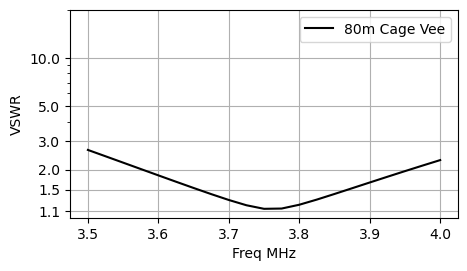

In [29]:
from necutil import nec5_sim_stdio3, plot_vswr, plot_vswr_2

# NEC5 template
nec_template = """CE Dipole
{gw_cards}
GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
EX 4 1 1 1 1.0 0.0
FR 0 {f_num} 0 0 {f_min} {f_step}
XQ 0
EN
"""

# Convert antenna to a set of 'GW' lines
gw_cards = gen_nec5_str(half_el, SEGS_PER_M, radius=0.001, tag=1)

# Fill in template
# Careful - use strip() to trim off trailing newline...NEC doesn't like blank lines
design = nec_template.format(gw_cards=gw_cards.strip(), f_num=21, f_min=3.5, f_step=0.025)

# ...and run simulation
res = nec5_sim_stdio3([design])
plot_vswr([res[0][0][0]], tags=['80m Cage Vee'])
